# thunder-python for large-scale SVD of images

Bioimage analysis is central to researchers in biology and biomedical clinicians and physicians, to name a few. Since the start of the era of "big data," it has become increasingly easier to capture and store large quantities of image data. However, the unique domain-specific properties of images makes large-scale analysis of images difficult.

A common operation in image analysis is to find the principal components of the images, perhaps for clustering and segmentation or for making predictions about unobserved data. This operation is typically very expensive, and does not scale beyond medium-sized datasets in its "traditional" form. Instead, we have to look to distributed methods to conduct similar analyses. This brief demo shows how we could pick out the top 10 principal components from the entire FERET image dataset.

## Pre-notebook steps

For completeness, we'll list here the steps we took to prepare the data and create the AWS cluster on which we'll be performing this demo.

1. Download the FERET image database. http://www.itl.nist.gov/iad/humanid/feret/feret_master.html .
2. Install the AWS command-line interface. This vastly simplifies the process of interacting with S3, Amazon's cloud-based storage service. The package name for this is `awscli`, and can be installed using the operating system package manager (e.g. `apt-get install awscli`) or with Python's package manager (e.g. `pip install awscli`).
3. Create an S3 bucket on AWS.

    `aws s3 mb s3://mybucket --region us-east-1`

4. Upload all the image data to the S3 bucket.

    `aws s3 cp local/path/to/images s3://mybucket/path --recursive`

5. Install thunder-python.

    `pip install thunder-python`

6. Use thunder-python's EC2 scripts to provision a compute cluster on AWS. There is great documentation available on the project webpage to help. http://thunder-project.org/thunder/docs/install_ec2.html

**IMPORTANT**: In the final step 6 above, make sure you use the option `--copy-aws-credentials` when provisioning the cluster. This will give your cluster direct access to S3. Otherwise you will need to copy your AWS access keys manually.

## IPython Notebook setup

Now we'll start with the Python portion. There are a few preliminaries when giving demos in an IPython notebook, so those are listed first.

In [1]:
# IPython Notebook preliminaries.
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
from thunder import Colorize
image = Colorize.image

## Read in the data

Now that all the setup is done, we're going to read in the image data we deposited earlier on S3 into a distributed data structure. If we were using vanilla Spark, this might be an entire operation unto itself, despite Spark's relatively high level of abstraction. However, since we're using thunder-python, it is built specifically to handle image and time series data, so it implements utility methods that make it very simple to read large image datasets into a robust distributed data structure.

In [3]:
# This pulls in all the .tif files at the S3 path and puts them into a Series data structure--an
# array-like entity that is distributed across the cluster.
images = tsc.loadImagesAsSeries("s3://squinn-bsec2015/feret", inputFormat = "tif")
images.cache()

Series
nrecords: None (inspect to compute)
dtype: float16
dims: min=(0, 0), max=(383, 255), count=(384, 256)
index: [    0     1     2 ..., 14048 14049 14050]

That's it! We've read all the images into a [Series](http://thunder-project.org/thunder/docs/generated/thunder.Series.html), a distributed 1-dimensional array of heterogeneous data. Now we can ask basic questions such as, how many images are we looking at? What does an image look like?

In [4]:
# How many images are we looking at?
print images.nrecords

98304


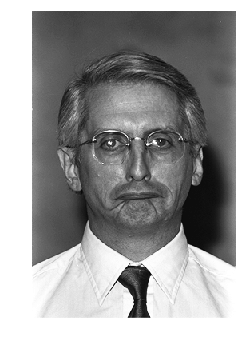

In [5]:
# Let's take a look at the first image.
i = images.toImages().first()[1]
image(i)

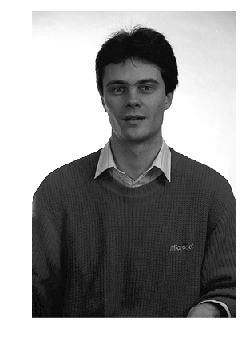

In [6]:
# Maybe another image, too?
i = images.toImages().get(2)
image(i)

## Perform the SVD

We have our image dataset of faces. Let's now compute the first 10 principal components, using a distributed SVD solver. We can do this by "stacking" all 98,304 images into a matrix, which is then decomposed. In practice, the images never leave whatever machine they're on--rather, the **code** is sent over the network and each image is annotated with its effective "row" in the matrix, which is used later to perform the actual SVD. All these details are hidden from the user.

In [7]:
# Import the PCA method. (http://thunder-project.org/thunder/docs/tutorials/factorization.html#pca)
from thunder import PCA

# Initialize our PCA model with k = 10 components, and then fit that model to our dataset.
model = PCA(k = 10).fit(images)

That took about an hour to run on all the images with 15 AWS instances. Here we'll reproduce the top 10 principal components.

In [8]:
components = model.scores.pack()
components.shape

(10, 384, 256)

As we see from the shape of the resulting components, we have 10 components, each 384 by 256 pixels. We'll plot each of those now.

/root/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


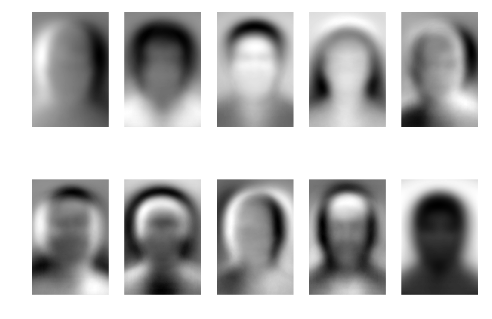

In [9]:
for img in range(components.shape[0]):
    plt.subplot(2, 5, img)
    image(components[img])